# Zoo Financial Exploratory Data Analysis
What is the motivation for conducting this analysis?

Exploring the CheckChicks' cashflow can reveal that...

Users who enjoy tracking their expenses and income might be,
depending on their approach and enthusiasm for financial management.
described as:

- **Budget-conscious** – Someone who carefully plans and monitors their spending.
- **Financially meticulous** – A person who pays close attention to financial details.
- **Expense tracker** – Someone who actively records their spending habits.
- **Frugal planner** – A person who enjoys optimizing their finances for savings.
- **Money-savvy** – Someone who is knowledgeable and strategic about finances.
- **Personal finance enthusiast** – A broader term for those who enjoy managing their money.
- **Data-driven spender** – Someone who makes financial decisions based on recorded data.
- **Financial optimizer** – A person who seeks to maximize efficiency in their financial habits.

On the other hand, users who don’t track their expenses and income regularly might be,
depending on their habits and attitudes toward financial management, described as such:

- **Spontaneous spender** – Someone who makes purchases without much planning.
- **Financially carefree** – A person who doesn’t stress about tracking money closely.
- **Unstructured budgeter** – Someone who manages finances loosely without detailed records.
- **Impulse buyer** – A person who tends to make purchases on a whim.
- **Money-agnostic** – Someone who doesn’t prioritize financial tracking.
- **Casual earner** – A person who earns and spends without strict oversight.
- **Non-budgeter** – Someone who avoids formal budgeting altogether.
- **Financially intuitive** – A person who relies on instinct rather than detailed tracking.

# Data Source

- acc_user
- acc_cashflow

In [1]:
import os
from sqlalchemy import create_engine
import pandas as pd

user = os.getenv("MYSQL_USER")
password = os.getenv("MYSQL_PASSWORD")
host = "localhost"
database = "zoo"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

## User Registration Date

In [2]:
## user registration , i.e. account creation, date

query = """
SELECT user_id, min(DATE(CREDTM)) registered
FROM zoo_checkchick2.ACC_USER
GROUP BY user_id
"""

users = pd.read_sql(query, con=engine,
                    dtype=({'registered':'datetime64[ns]'}))
users.describe()

,registered
count,651992
mean,2020-02-18 09:02:58.765383936
min,2018-06-01 00:00:00
25%,2018-11-06 00:00:00
50%,2019-07-30 00:00:00
75%,2021-01-06 00:00:00
max,2025-02-08 00:00:00


In [3]:
# user cohorts by registered year

query = """
SELECT
  year(CREDTM) registered_yr,
  count(*) n_new_user
FROM (
  SELECT
    USER_ID,
    min(CREDTM) AS CREDTM
    FROM zoo_checkchick2.ACC_USER
	GROUP BY USER_ID
) AS foo
  GROUP BY registered_yr
  ORDER BY registered_yr
;
"""

pd.read_sql(query, con=engine)

,registered_yr,n_new_user
0,2018,222820
1,2019,174811
2,2020,90177
3,2021,71313
4,2022,32906
5,2023,34311
6,2024,23866
7,2025,1788


## Cashflow

In [4]:
# check number of records (expense and income entries) each month

query = """
SELECT DATE_FORMAT(date, '%%Y-%%m') yyyy_mm,
  COUNT(*) total,
  SUM(is_expense) nbr_expense_entry,
  SUM(is_group) nbr_group_entry
FROM zoo.acc_cashflow
GROUP BY yyyy_mm
"""

df = pd.read_sql(query, con=engine)
df.describe()

,total,nbr_expense_entry,nbr_group_entry
count,170.000000,170.000000,170.000000
mean,207616.941176,194336.658824,32174.147059
std,228406.501617,214520.345511,36185.704552
min,1.000000,0.000000,0.000000
25%,3.000000,3.000000,0.000000
50%,232.500000,170.500000,44.500000
75%,416924.000000,386208.000000,65632.750000
max,841703.000000,818109.000000,102861.000000


_**Observation:**_ Half of the periods in the data set have very low number of records each month. Erroneous date?

/var/folders/mx/2pv6svr934z2z3jpglc18x6w0000gn/T/ipykernel_50897/919137837.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _.set_xticklabels([label if i % 4 == 0 else '' for i, label in enumerate(df_melted['yyyy_mm'])], rotation=90)


Text(0, 0.5, 'Count')

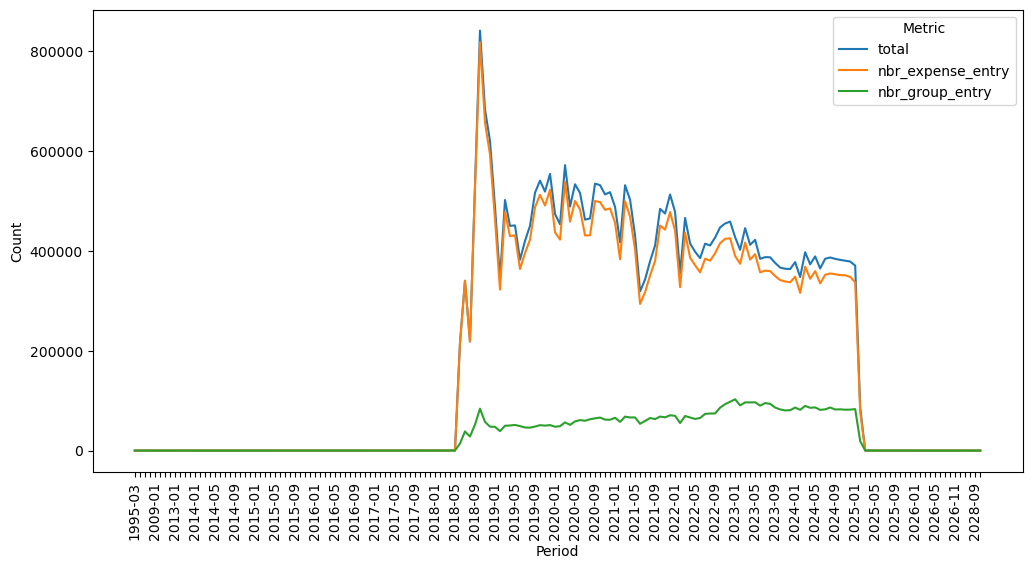

In [5]:
import seaborn as sns

# Reshape data for Seaborn
df_melted = df.melt(id_vars=['yyyy_mm'], var_name='Metric', value_name='Value')
df_melted['yyyy_mm'] = df_melted['yyyy_mm'].astype('string')

_ = sns.lineplot(data=df_melted, x='yyyy_mm', y='Value', color='skyblue', hue='Metric')

# Rotate X-axis labels directly within Seaborn
# Reduce tick labels by selecting every 4th label
_.set_xticklabels([label if i % 4 == 0 else '' for i, label in enumerate(df_melted['yyyy_mm'])], rotation=90)

_.figure.set_size_inches(12, 6)
_.set_xlabel('Period')
_.set_ylabel('Count')
# ax.set_title('Vertical Bar Chart with Rotated Date Labels')

# ax.figure.show()  # Ensure proper display without Matplotlib calls

__*Observation:*__
- errorenous timestamps
- personal entries makes up significally larger portions of records; I had expected more entries. 
- expenses makes up larger portion of the records; this aligns with the norm for personal finance dataset.

In [6]:
# cashflow dataset
# left and right date range censored to exclude erroneous rows

cashflow = pd.read_sql("SELECT * FROM zoo.acc_cashflow WHERE date BETWEEN '2018-06-01' AND '2025-01-31'",
                       con=engine,
                       dtype={'date':'datetime64[ns]', 'is_expense':'bool', 'is_group':'bool'})
cashflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35205617 entries, 0 to 35205616
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   date         datetime64[ns]
 2   amt          float64       
 3   is_expense   bool          
 4   is_group     bool          
 5   group_id     object        
 6   category_id  int64         
 7   category     object        
 8   note         object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.9+ GB


_**n.b.,**_ __amt__ is float64. _I expect this to be whole number._

In [7]:
cashflow.isna().sum()

user_id               0
date                  0
amt                   0
is_expense            0
is_group              0
group_id       29755562
category_id           0
category         785454
note                  0
dtype: int64

In [8]:
print(cashflow.group_id.count() / cashflow.shape[0])

0.15480640489840017


_**Observation:**_ group entries make up about 15% of the records.

_**Question:**_ Should factional amounts be rounded up?

In [9]:
# should amt be whole number?
bad = cashflow.query("amt % 1 != 0").copy()
bad.describe()

,date,amt,category_id
count,130958,1.309580e+05,130958.000000
mean,2022-08-04 07:28:22.109073152,-3.658672e+02,2833.819492
min,2018-06-21 00:00:00,-2.222222e+07,0.000000
25%,2021-04-14 00:00:00,-4.160000e+01,1.000000
50%,2022-11-16 00:00:00,-1.340000e+01,2.000000
75%,2024-01-05 00:00:00,-4.152500e+00,5.000000
max,2025-01-31 00:00:00,1.000000e+07,75967.000000
std,NaN,9.389124e+04,10857.694536


In [10]:
# create quartile bins
bad['quartile'] = pd.qcut(bad['amt'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
bad.groupby('quartile', observed=True).agg({'amt':['count', 'sum', 'mean']})

amt                           
          count           sum         mean
quartile                                  
Q1        32784 -7.720933e+07 -2355.091667
Q2        32775 -7.892596e+05   -24.081147
Q3        32659 -2.640294e+05    -8.084430
Q4        32740  3.034938e+07   926.981693

In [11]:
bad.groupby(['quartile', 'is_expense'], observed=True).agg({'amt':'sum'}).unstack(level=1)

amt              
is_expense         False         True 
quartile                              
Q1                   NaN -7.720933e+07
Q2                   NaN -7.892596e+05
Q3                   NaN -2.640294e+05
Q4          3.039394e+07 -4.456345e+04

In [12]:
bad['category'].unique()

array(['飲食', '日常', '交通', ..., '資源回收', 'IG', '欠瑜'],
      shape=(1435,), dtype=object)

In [13]:
bad['note'].unique()

array(['食材', '麥當勞', '茶飲料', ..., '1/10薪水', 'myki card賣出', '01/24薪水'],
      shape=(49439,), dtype=object)

In [14]:
cashflow['amt'] = cashflow['amt'].round().astype('Int64')

In [15]:
cashflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35205617 entries, 0 to 35205616
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   date         datetime64[ns]
 2   amt          Int64         
 3   is_expense   bool          
 4   is_group     bool          
 5   group_id     object        
 6   category_id  int64         
 7   category     object        
 8   note         object        
dtypes: Int64(1), bool(2), datetime64[ns](1), int64(1), object(4)
memory usage: 1.9+ GB


In [16]:
# Should rows where amount is 0 be excluded?

cashflow[cashflow.amt == 0].count()

user_id        4620
date           4620
amt            4620
is_expense     4620
is_group       4620
group_id        233
category_id    4620
category       4541
note           4620
dtype: int64

In [17]:
# check number of active users in each month, i.e. period

cashflow['yyyy_mm'] = cashflow['date'].dt.to_period('M')
cashflow['yyyy'] = cashflow['date'].dt.year
cashflow['mm'] = cashflow['date'].dt.month

#cashflow.groupby(['yyyy', 'mm']).agg({'user_id':'nunique'}).unstack(level=1)

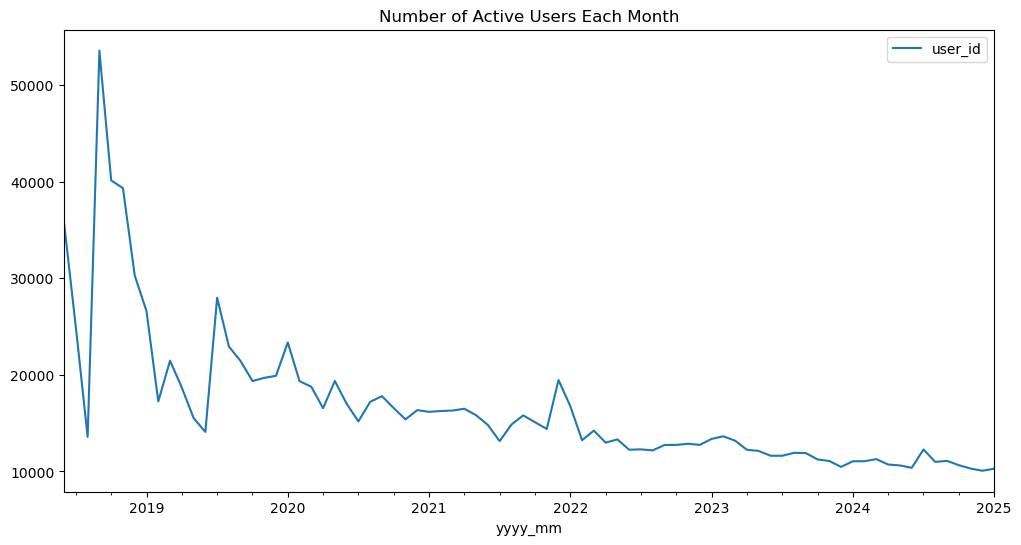

In [18]:
_ = cashflow.groupby('yyyy_mm').agg({'user_id':'nunique'}) \
    .plot(y='user_id', kind='line', figsize=(12, 6), title="Number of Active Users Each Month")

__*Observation:*__ number of active users gradually declined but not obvious

In [19]:
cashflow.describe()

,date,amt,category_id,yyyy,mm
count,35205617,35205617.0,3.520562e+07,3.520562e+07,3.520562e+07
mean,2021-07-31 02:12:30.383510016,211.797213,1.281901e+03,2.021059e+03,6.795657e+00
min,2018-06-01 00:00:00,-99999999.0,0.000000e+00,2.018000e+03,1.000000e+00
25%,2019-12-15 00:00:00,-300.0,1.000000e+00,2.019000e+03,4.000000e+00
50%,2021-06-09 00:00:00,-106.0,1.000000e+00,2.021000e+03,7.000000e+00
75%,2023-03-02 00:00:00,-53.0,4.000000e+00,2.023000e+03,1.000000e+01
max,2025-01-31 00:00:00,99999999.0,7.610900e+04,2.025000e+03,1.200000e+01
std,NaN,389861.849207,6.982359e+03,1.924690e+00,3.531527e+00


# Expense by Category
_to-do:_ move under EDA and use _**cashflow**_ instead of calling db

## Private Entry

In [20]:
query = """
SELECT B.CATEGORY,
  count(DISTINCT USER_ID) n_user,
  count(*) nbr_expense,
  round(count(*) / count(DISTINCT USER_ID), 2) nbr_expsense_per_user,  
  round(AVG(AMOUNT)) avg_amt
FROM zoo.ACC_USER_DETAIL A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
    ON A.CATEGORY = B.ID
GROUP BY A.CATEGORY
ORDER BY nbr_expense DESC 
;
"""

pd.read_sql(query, con=engine)

,CATEGORY,n_user,nbr_expense,nbr_expsense_per_user,avg_amt
0,飲食,308559,16104705,52.19,576.0
1,日常,142600,2327199,16.32,1816.0
2,交通,148082,2162896,14.61,1112.0
3,其他,162467,1798762,11.07,3261.0
4,娛樂,121354,1171783,9.66,4674.0
...,...,...,...,...,...
37982,紓困手機,1,1,1.00,5000.0
37983,還淑蕓,1,1,1.00,500.0
37984,油錢（汽,1,1,1.00,1100.0
37985,Irent,1,1,1.00,1153.0


## Group Entry

In [21]:
query = """
SELECT B.CATEGORY,
  count(DISTINCT USER_ID) n_user,
  count(*) nbr_expense,
  round(count(*) / count(DISTINCT USER_ID), 2) nbr_expsense_per_user,  
  round(AVG(AMOUNT)) avg_amt
	FROM zoo_checkchick.ACC_GROUP_DETAIL A
		LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
		ON A.CATEGORY = B.ID
  GROUP BY A.CATEGORY
  ORDER BY nbr_expense DESC
"""

pd.read_sql(query, con=engine)

,CATEGORY,n_user,nbr_expense,nbr_expsense_per_user,avg_amt
0,飲食,40084,2629208,65.59,415.0
1,日常,22282,437774,19.65,2328.0
2,交通,22594,364329,16.13,1122.0
3,其他,22839,277630,12.16,5422.0
4,娛樂,19476,178466,9.16,3628.0
...,...,...,...,...,...
15347,工讀金,1,1,1.00,3600.0
15348,MOD費,1,1,1.00,1199.0
15349,開伙,1,1,1.00,60.0
15350,豆乳❤️,1,1,1.00,99.0


# Tidy Dataset

## Tenure

In [22]:
# user tenure, income and expense entry stats,
# including group entries
# excluding amount = 0
# n.b. tenure begin when user submit first entry, and does not consider
#      when user first registered with the app

tenure = cashflow[cashflow.amt != 0] \
    .groupby('user_id') \
    .agg(user_tenure = ('date', lambda x: x.max() - x.min()),
         first_entry = ('date', 'min'),
         last_entry = ('date', 'max'),
         nbr_entry = ('user_id', 'count'),
         total_exp = ('amt', lambda x: x[x < 0].sum()),
         nbr_exp = ('amt', lambda x: x[x < 0].count()),
         total_inc = ('amt', lambda x: x[x > 0].sum()),
         nbr_inc = ('amt', lambda x: x[x > 0].count())
        )
tenure.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399110 entries, 20190114221435UXD to Ufffffd83c214154e0427c19f1a97b293
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype          
---  ------       --------------   -----          
 0   user_tenure  399110 non-null  timedelta64[ns]
 1   first_entry  399110 non-null  datetime64[ns] 
 2   last_entry   399110 non-null  datetime64[ns] 
 3   nbr_entry    399110 non-null  int64          
 4   total_exp    399110 non-null  Int64          
 5   nbr_exp      399110 non-null  Int64          
 6   total_inc    399110 non-null  Int64          
 7   nbr_inc      399110 non-null  Int64          
dtypes: Int64(4), datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 28.9+ MB


In [23]:
tenure.describe()

,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc
count,399110,399110,399110,399110.000000,399110.0,399110.0,399110.0,399110.0
mean,213 days 07:32:40.223497284,2020-01-10 11:32:41.883190016,2020-08-10 19:05:22.106687744,88.198735,-126604.914555,82.565581,145287.6125,5.633154
min,0 days 00:00:00,2018-06-01 00:00:00,2018-06-03 00:00:00,1.000000,-4135128073.0,0.0,0.0,0.0
25%,0 days 00:00:00,2018-10-01 00:00:00,2018-12-07 00:00:00,2.000000,-16033.0,2.0,0.0,0.0
50%,7 days 00:00:00,2019-06-29 00:00:00,2019-12-17 00:00:00,7.000000,-2336.5,7.0,0.0,0.0
75%,139 days 00:00:00,2020-10-05 00:00:00,2021-12-12 00:00:00,32.000000,-327.0,29.0,9997.5,1.0
max,2436 days 00:00:00,2025-01-31 00:00:00,2025-01-31 00:00:00,35515.000000,0.0,25720.0,5959084893.0,26923.0
std,452 days 19:06:48.118525888,NaN,NaN,417.039147,8975724.512895,382.715875,13838559.350852,102.54491


_**Initial observation:**_ Of the 399,125 users, 25% of which had logged entries in the last 48~50 days 

In [24]:
cashflow.groupby(['user_id', 'is_group', 'is_expense'])['category_id'].nunique().unstack(level=[1,2], fill_value=0).describe()

is_group            False          True                          False
is_expense          True           True           False          False
count       399125.000000  399125.000000  399125.000000  399125.000000
mean             3.058087       0.525720       0.114363       0.660998
std              2.858130       1.917031       0.637080       1.205453
min              0.000000       0.000000       0.000000       0.000000
25%              1.000000       0.000000       0.000000       0.000000
50%              2.000000       0.000000       0.000000       0.000000
75%              4.000000       0.000000       0.000000       1.000000
max             59.000000      62.000000      43.000000      24.000000

_**Observation:**_ Is it true that entries are not well categorized by the bottom 75% of users?

## Group Entry

In [25]:
# user group expense and income entry stat per user

td_grp = cashflow[(cashflow.amt != 0) & (cashflow.is_group == True)] \
    .groupby('user_id') \
    .agg(n_grp = ('group_id', 'nunique'),
         first_grp_entry = ('date', 'min'),
         last_grp_entry = ('date', 'max'),
         grp_exp = ('amt', lambda x: x[x < 0].sum()),
         nbr_grp_exp = ('amt', lambda x: x[x < 0].count()),
         grp_inc = ('amt', lambda x: x[x > 0].sum()),
         nbr_grp_inc = ('amt', lambda x: x[x > 0].count())
        )
td_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54840 entries, U00012edc9efabb05d4c4aebcbbb0d04f to Uffffba3f764fadbe1465991b9a9e200d
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   n_grp            54840 non-null  int64         
 1   first_grp_entry  54840 non-null  datetime64[ns]
 2   last_grp_entry   54840 non-null  datetime64[ns]
 3   grp_exp          54840 non-null  Int64         
 4   nbr_grp_exp      54840 non-null  Int64         
 5   grp_inc          54840 non-null  Int64         
 6   nbr_grp_inc      54840 non-null  Int64         
dtypes: Int64(4), datetime64[ns](2), int64(1)
memory usage: 3.6+ MB


In [26]:
td_grp.describe()

,n_grp,first_grp_entry,last_grp_entry,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,54840.000000,54840,54840,54840.0,54840.0,54840.0,54840.0
mean,1.413220,2021-02-27 17:23:14.310722304,2021-09-02 13:35:44.245076224,-151100.554048,92.041357,119858.343563,7.335412
min,1.000000,2018-06-01 00:00:00,2018-06-06 00:00:00,-299999997.0,0.0,0.0,0.0
25%,1.000000,2019-03-08 00:00:00,2019-09-03 00:00:00,-33414.5,2.0,0.0,0.0
50%,1.000000,2021-01-05 00:00:00,2021-08-25 00:00:00,-4897.5,8.0,0.0,0.0
75%,1.000000,2023-01-01 00:00:00,2023-07-05 00:00:00,-523.0,44.0,10279.25,2.0
max,123.000000,2025-01-31 00:00:00,2025-01-31 00:00:00,0.0,23868.0,377401583.0,5852.0
std,1.549708,NaN,NaN,2187024.897025,364.001904,2406729.629232,68.579992


## Group Bookkeepers

self-joined group_id:user_id from _cashflow_ to compute
number of distinct users interacted within groups

In [27]:
grp = cashflow.loc[(cashflow.amt != 0) & (cashflow.group_id.notnull()), ['group_id', 'user_id']].drop_duplicates()
grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77501 entries, 27909417 to 35205606
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   group_id  77501 non-null  object
 1   user_id   77501 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [28]:
x = grp[['user_id', 'group_id']].merge(grp[['user_id', 'group_id']], on='group_id', how='left')
x.describe()

,user_id_x,group_id,user_id_y
count,142497,142497,142497
unique,54840,52179,54840
top,Ud55b2379d1eb274345541f6ae0387352,,Ud55b2379d1eb274345541f6ae0387352
freq,129,3721,129


In [29]:
y = x.groupby('user_id_x').agg({'group_id': 'nunique', 'user_id_y':'nunique'}).reset_index()
y.columns = ['user_id', 'n_group', 'nbr_connection']
y.describe()

,n_group,nbr_connection
count,54840.000000,54840.000000
mean,1.413220,2.074654
std,1.549708,2.620270
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.000000,2.000000
max,123.000000,67.000000


_**Observation:**_ Groups with only one participant should be excluded in the stat summary.

## 

In [48]:
y[y.nbr_connection > 1].describe()

,n_group,nbr_connection
count,40737.000000,40737.000000
mean,1.478999,2.446695
std,1.684618,2.950347
min,1.000000,2.000000
25%,1.000000,2.000000
50%,1.000000,2.000000
75%,1.000000,2.000000
max,123.000000,67.000000


In [31]:
y[y.n_group >= 15]

,user_id,n_group,nbr_connection
256,U0138d2168ba1bb918e07e9cf6327a327,28,2
696,U03362028c15ceafe6b35a1e9144e7fbc,19,2
934,U0448f1a59d0a48704852f05e5f1dce62,23,2
1122,U0526a31e1147b9d82a93b864156d793f,16,1
1165,U05574487ef7b11dd9aba3bd324bae7b1,22,2
...,...,...,...
47816,Udfa9d43acffa733aa40ce6798d632010,16,3
48062,Ue0bc846dfe0f75c11289268d13f2594a,26,7
49124,Ue5dacb8ef101ce8895d9ebdac1d9c137,21,3
49694,Ue8689784a2326f04b9375db32b22de53,20,2


In [32]:
tenure.query("user_id == 'Ue5dacb8ef101ce8895d9ebdac1d9c137'")

,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc
user_id,,,,,,,,
Ue5dacb8ef101ce8895d9ebdac1d9c137,680 days,2019-08-27,2021-07-07,93,-207605,86,156608,7


n_grp may include group where User is the only participant where as n_group counts only groups with participants besides the User

In [33]:
tenure[tenure.index == 'Uad037354f8e93f5767b9c75a1ed509d8']


,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc
user_id,,,,,,,,
Uad037354f8e93f5767b9c75a1ed509d8,2228 days,2018-12-26,2025-01-31,2999,-4137016,2994,12500,5


In [34]:
tenure[tenure.index == 'U6b4dd31bce7f6628ad86280dc8750055']

,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc
user_id,,,,,,,,
U6b4dd31bce7f6628ad86280dc8750055,645 days,2019-08-28,2021-06-03,809,-390731,753,43036,56


## 

## Merge and Impute

In [35]:
td = users.merge(tenure, on='user_id', how='right').merge(td_grp, on='user_id', how='left')
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399110 entries, 0 to 399109
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   user_id          399110 non-null  object         
 1   registered       397394 non-null  datetime64[ns] 
 2   user_tenure      399110 non-null  timedelta64[ns]
 3   first_entry      399110 non-null  datetime64[ns] 
 4   last_entry       399110 non-null  datetime64[ns] 
 5   nbr_entry        399110 non-null  int64          
 6   total_exp        399110 non-null  Int64          
 7   nbr_exp          399110 non-null  Int64          
 8   total_inc        399110 non-null  Int64          
 9   nbr_inc          399110 non-null  Int64          
 10  n_grp            54840 non-null   float64        
 11  first_grp_entry  54840 non-null   datetime64[ns] 
 12  last_grp_entry   54840 non-null   datetime64[ns] 
 13  grp_exp          54840 non-null   Int64          
 14  nbr_

In [36]:
td.describe()

,registered,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc,n_grp,first_grp_entry,last_grp_entry,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,397394,399110,399110,399110,399110.000000,399110.0,399110.0,399110.0,399110.0,54840.000000,54840,54840,54840.0,54840.0,54840.0,54840.0
mean,2019-11-28 01:26:46.906999808,213 days 07:32:40.223497284,2020-01-10 11:32:41.883190016,2020-08-10 19:05:22.106687744,88.198735,-126604.914555,82.565581,145287.6125,5.633154,1.413220,2021-02-27 17:23:14.310722560,2021-09-02 13:35:44.245076736,-151100.554048,92.041357,119858.343563,7.335412
min,2018-06-01 00:00:00,0 days 00:00:00,2018-06-01 00:00:00,2018-06-03 00:00:00,1.000000,-4135128073.0,0.0,0.0,0.0,1.000000,2018-06-01 00:00:00,2018-06-06 00:00:00,-299999997.0,0.0,0.0,0.0
25%,2018-09-25 00:00:00,0 days 00:00:00,2018-10-01 00:00:00,2018-12-07 00:00:00,2.000000,-16033.0,2.0,0.0,0.0,1.000000,2019-03-08 00:00:00,2019-09-03 00:00:00,-33414.5,2.0,0.0,0.0
50%,2019-03-28 00:00:00,7 days 00:00:00,2019-06-29 00:00:00,2019-12-17 00:00:00,7.000000,-2336.5,7.0,0.0,0.0,1.000000,2021-01-05 00:00:00,2021-08-25 00:00:00,-4897.5,8.0,0.0,0.0
75%,2020-06-29 00:00:00,139 days 00:00:00,2020-10-05 00:00:00,2021-12-12 00:00:00,32.000000,-327.0,29.0,9997.5,1.0,1.000000,2023-01-01 00:00:00,2023-07-05 00:00:00,-523.0,44.0,10279.25,2.0
max,2025-02-07 00:00:00,2436 days 00:00:00,2025-01-31 00:00:00,2025-01-31 00:00:00,35515.000000,0.0,25720.0,5959084893.0,26923.0,123.000000,2025-01-31 00:00:00,2025-01-31 00:00:00,0.0,23868.0,377401583.0,5852.0
std,NaN,452 days 19:06:48.118525888,NaN,NaN,417.039147,8975724.512895,382.715875,13838559.350852,102.54491,1.549708,NaN,NaN,2187024.897025,364.001904,2406729.629233,68.579992


# EDA

In [37]:
# select users having made at least 1 entry in the past 50 days

t1 = max(tenure.last_entry)
t0 = t1 - pd.Timedelta(days=50)

tenure.loc[tenure.last_entry >= t0,]['nbr_entry'].quantile([0.25, 0.5, 0.75])
# td.last_entry >= t0 & td.last_entry < t1 

0.25      60.0
0.50     403.0
0.75    1674.5
Name: nbr_entry, dtype: float64

In [38]:
tenure.loc[tenure.last_entry >= t0,]['nbr_entry'].count()

np.int64(11578)

In [41]:
#number of members in each group
nbr_mbr_grp = cashflow.query("is_group == True").groupby('group_id')['user_id'].nunique()

nbr_mbr_grp.agg(['min', 'max', 'mean', 'median'])

min        1.000000
max       61.000000
mean       1.485331
median     1.000000
Name: user_id, dtype: float64

In [42]:
nbr_mbr_grp.quantile([.25, .5, .75, .8, .9, .95, .99])

0.25    1.0
0.50    1.0
0.75    2.0
0.80    2.0
0.90    2.0
0.95    2.0
0.99    3.0
Name: user_id, dtype: float64

# Supplemental

```sql
-- consolidate expense and income entry to simplify analysis

USE zoo;

DROP TABLE IF EXISTS acc_cashflow;

CREATE TABLE acc_cashflow (
  user_id VARCHAR(100) NOT NULL,
  date DATE NOT NULL,
  amt DOUBLE NOT NULL,
  is_expense BOOLEAN,
	is_group BOOLEAN,
  group_id VARCHAR(100),
  category_id INT,
  category VARCHAR(100),
  note VARCHAR(160)
) COMMENT = 'consolidated expense and income entries'
;

-- insert personal expense
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  -AMOUNT amt,
  TRUE is_expense,
	FALSE is_group,
  NULL group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo.ACC_USER_DETAIL A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
ON A.CATEGORY = B.ID
;

-- insert group expense
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  -AMOUNT amt,
  TRUE is_expense,
	TRUE is_group,
  GROUP_ID group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick.ACC_GROUP_DETAIL A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
ON A.CATEGORY = B.ID
;

-- insert personal income
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  AMOUNT amt,
  FALSE is_expense,
	FALSE is_group,
  NULL group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick2.ACC_USER_DETAIL_INCOME A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY_INCOME B
ON A.CATEGORY = B.ID
;

-- insert group income
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  AMOUNT amt,
  FALSE is_expense,
	TRUE is_group,
  GROUP_ID group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick2.ACC_GROUP_DETAIL_INCOME A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY_INCOME B
ON A.CATEGORY = B.ID
;
```